In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
workspace_dir = "."
!cp "/content/drive/MyDrive/CSCI_635/facades.tar.gz" "{workspace_dir}"

In [4]:
!tar -xf /content/facades.tar.gz

In [ ]:
# !pip install torchvision --upgrade

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import os
from torchvision.io import read_image
import torchvision.transforms as tv_transforms
import matplotlib.pyplot as plt
from torch.nn import functional as functional
import numpy as np
from scipy.interpolate import CubicSpline

In [6]:
# Define constants
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 1


In [7]:
class Transformer(object):
    """"Transform"""
    def __init__(self,):
        pass
    def __call__(self, imgA, imgB=None):
        pass


class ToTensor(Transformer):
    """Convert imageA and imageB to torch.tensor"""
    def __init__(self,):
        super().__init__()

    def __call__(self, imgA, imgB=None):
        imgA = np.array(imgA)/255.
        imgA = torch.from_numpy(imgA).float().permute(2, 0, 1)
        if imgB is None:
            return imgA
        imgB = np.array(imgB)/255.
        imgB = torch.from_numpy(imgB).float().permute(2, 0, 1)
        return imgA, imgB

In [8]:
class ImageDataset(Dataset):
    def __init__(self, file_paths, random_changes=True):
        self.file_paths = file_paths
        self.random_changes = random_changes

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        input_image, real_image = self.load_image(self.file_paths[idx])
        return input_image, real_image

    def load_image(self, image_file):
        img = Image.open(image_file).convert('RGB')

        # Split the image into left and right halves
        width = img.width
        real_image = img.crop((0, 0, width // 2, img.height))
        input_image = img.crop((width // 2, 0, width, img.height))

        transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
        ])

        input_image = transform(input_image)
        real_image = transform(real_image)
        return input_image, real_image

    def make_random_changes(self, input_image, real_image):
        return input_image, real_image


In [9]:
train_dataset = ImageDataset(file_paths=glob.glob('/content/facades/train/*.jpg'))
test_dataset = ImageDataset(file_paths=glob.glob('/content/facades/val/*.jpg'))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input_src, input_target):
        merged = torch.cat([input_src, input_target], dim=1)
        return self.model(merged.clone())


In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super(EncoderBlock, self).__init__()

        layers = [
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        ]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=True):
        super(DecoderBlock, self).__init__()

        layers = [
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)

        ]

        if dropout:
            layers.append(nn.Dropout2d(p=0.5, inplace=True))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        # if skip is not None:
        #   x = torch.cat([x, skip], dim=1)
        return x


In [13]:
class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3):
        super(Generator, self).__init__()

        # Encoder
        self.e1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        self.e5 = EncoderBlock(512, 512)
        self.e6 = EncoderBlock(512, 512)
        self.e7 = EncoderBlock(512, 512)
        self.e8 = EncoderBlock(512, 512, batch_norm=False)

        # Bottleneck
        self.b = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.d8 = DecoderBlock(512, 512)
        self.d7 = DecoderBlock(2*512, 512)
        self.d6 = DecoderBlock(2*512, 512)
        self.d5 = DecoderBlock(2*512, 512, dropout=False)
        self.d4 = DecoderBlock(2*512, 256, dropout=False)
        self.d3 = DecoderBlock(2*256, 128, dropout=False)
        self.d2 = DecoderBlock(2*128, 64, dropout=False)
        self.d1 = nn.ConvTranspose2d(2*64, 3, kernel_size=4, stride=2, padding=1)

        # Output
        self.out_image = nn.Sequential(
            #nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        e8 = self.e8(e7)

        d8 = self.d8(e8)
        d8 = torch.cat([d8, e7], dim=1)
        d7 = self.d7(d8)
        d7 = torch.cat([d7, e6], dim=1)
        d6 = self.d6(d7)
        d6 = torch.cat([d6, e5], dim=1)
        d5 = self.d5(d6)
        d5 = torch.cat([d5, e4], dim=1)
        d4 = self.d4(d5)
        d4 = torch.cat([d4, e3], dim=1)
        d3 = self.d3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d2 = functional.relu(self.d2(d3))
        d2 = torch.cat([d2, e1], dim=1)
        d1 = self.d1(d2)
        return self.out_image(d1)


In [14]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, input_image, target, g_criterion,d_criterion):
        # Forward pass through the generator
        generated_images = self.generator(input_image)

        # Forward pass through the discriminator
        fake_dis_prediction = self.discriminator(generated_images, input_image)

        gen_loss = g_criterion(generated_images, target, fake_dis_prediction)

        fake_dis_pred_detach = self.discriminator(self.generator(input_image).detach(), input_image)
        real_dis_prediction = self.discriminator(input_image, input_image)

        d_loss = d_criterion(fake_dis_pred_detach, real_dis_prediction)

        #return real_dis_prediction, fake_dis_prediction, fake_dis_pred_detach, generated_images
        return gen_loss, d_loss


In [15]:
input_channels = 3  # Adjust this based on your actual input channels
generator = Generator(input_channels=input_channels, output_channels=3).to('cuda:0')
discriminator = Discriminator(input_channels=input_channels).to('cuda:0')
print(generator)
print("--------------------------------------------------")
print(discriminator)


Generator(
  (e1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (e2): EncoderBlock(
    (model): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (e3): EncoderBlock(
    (model): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (e4): EncoderBlock(
    (model): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (e5): EncoderBlock(
    (model): Sequential(
      (0): LeakyReLU(

In [16]:
gan = GAN(generator, discriminator).to('cuda:0')

# Loss function
criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [17]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [18]:
class GeneratorLoss(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha=alpha
        self.bce=nn.BCEWithLogitsLoss()
        self.l1=nn.L1Loss()

    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss = self.bce(fake_pred, fake_target) + self.alpha* self.l1(fake, real)
        return loss


class DiscriminatorLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss)/2
        return loss


def discriminator_loss(fake_labels, real_labels):
    real_loss = criterion(real_labels, torch.ones_like(real_labels))
    fake_loss = criterion(fake_labels, torch.zeros_like(fake_labels))
    disc_loss = (real_loss + fake_loss)/2

def generator_loss(fake_dis_prediction, generated_images, target):
    return criterion(fake_dis_prediction, torch.ones_like(fake_dis_prediction))


For epoch = 100
Validation Generator Loss: 36.0259158706665, Validation Discriminator Loss: 0.7246856927871704
Validation Generator Accuracy: 0.4995555555555555
Average SNR: 0.38718542535905726 dB 

For epoch = 250
Validation Generator Loss: 36.362441291809084, Validation Discriminator Loss: 0.7246419888734817
Validation Generator Accuracy: 0.49848888888888865
Average SNR: 0.3355398828163743 dB 

For epoch = 500
Validation Generator Loss: 36.039500617980956, Validation Discriminator Loss: 0.7247248303890228
Validation Generator Accuracy: 0.496888888888889
Average SNR: 0.4206678062491119 dB 



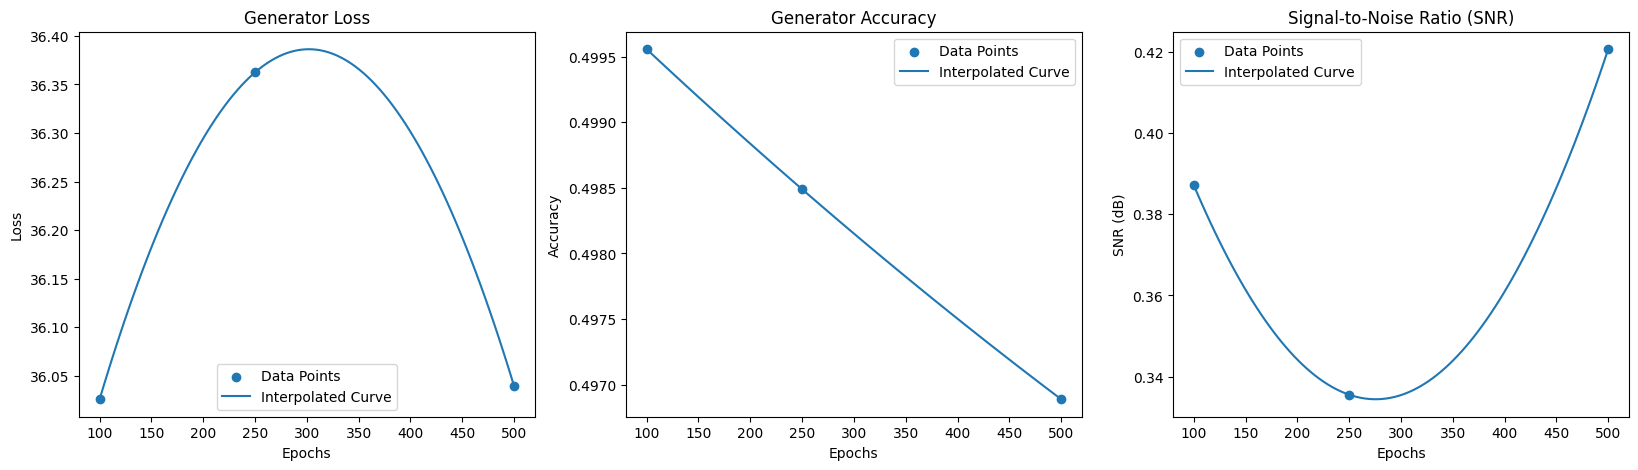

In [21]:
def load_model(model, model_path):
    # Load the state_dict
    state_dict = torch.load(model_path)

    # Check if the model is a Discriminator or Generator
    is_discriminator = hasattr(model, 'model')
    prefix = 'model.' if is_discriminator else ''

    # Filter out unnecessary keys
    state_dict = {prefix + k: v for k, v in state_dict.items() if (prefix + k) in model.state_dict()}

    # Load the state_dict into the model
    model.load_state_dict(state_dict, strict=False)

    # Set the model to evaluation mode
    model.eval()

    return model

def calculate_snr(original, generated):
    # Calculate signal power
    signal_power = torch.mean(original ** 2)

    # Calculate noise power
    noise = original - generated
    noise_power = torch.mean(noise ** 2)

    # Calculate SNR in dB
    snr = 10 * torch.log10(signal_power / noise_power)

    return snr.item()

def calculate_accuracy(predictions, targets):
    """
    Calculate accuracy given the predictions and true targets.
    Assumes binary classification.
    """
    with torch.no_grad():
        # Convert predictions to binary values (0 or 1)
        predicted_labels = (predictions > 0.5).float()

        # Calculate accuracy
        correct_predictions = (predicted_labels == targets).sum().item()
        total_samples = targets.numel()
        accuracy = correct_predictions / total_samples

    return accuracy


def validate(generator, discriminator, validation_dataloader, g_criterion, d_criterion, epoch):
    generator.eval()
    discriminator.eval()

    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_gen_accuracy = 0.0
    total_snr = 0.0

    with torch.no_grad():
        for input_image, target in validation_dataloader:
            input_image, target = input_image.to('cuda:0'), target.to('cuda:0')

            # Forward pass
            gen_loss, disc_loss = gan(input_image, target, g_criterion, d_criterion)

            # Calculate accuracy
            generated_images = generator(input_image)
            fake_dis_prediction = discriminator(generated_images, input_image)
            gen_accuracy = calculate_accuracy(fake_dis_prediction, torch.ones_like(fake_dis_prediction))

            # Calculate SNR
            snr = calculate_snr(target, generated_images)

            total_gen_loss += gen_loss.item()
            total_disc_loss += disc_loss.item()
            total_gen_accuracy += gen_accuracy
            total_snr += snr

    avg_gen_loss = total_gen_loss / len(validation_dataloader)
    avg_disc_loss = total_disc_loss / len(validation_dataloader)
    avg_gen_accuracy = total_gen_accuracy / len(validation_dataloader)
    avg_snr = total_snr / len(validation_dataloader)
    print(f'For epoch = {epoch}')
    print(f"Validation Generator Loss: {avg_gen_loss}, Validation Discriminator Loss: {avg_disc_loss}")
    print(f"Validation Generator Accuracy: {avg_gen_accuracy}")
    print(f"Average SNR: {avg_snr} dB \n")

    return avg_gen_loss, avg_disc_loss, avg_gen_accuracy, avg_snr

# Assuming you already have a validation dataloader
validation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Load the trained model
model_path = '/content/drive/MyDrive/CSCI_635/checkpoints/generator_100.pth'
generator = load_model(generator, model_path)
discriminator = load_model(discriminator, model_path)

# Call the validate function after loading the model
gen_loss1, disc_loss1, gen_accuracy1, snr1 = validate(generator, discriminator, validation_dataloader, GeneratorLoss(alpha=100), DiscriminatorLoss(),100)

# Load the trained model
model_path = '/content/drive/MyDrive/CSCI_635/checkpoints/generator_250.pth'
generator = load_model(generator, model_path)
discriminator = load_model(discriminator, model_path)

# Call the validate function after loading the model
gen_loss2, disc_loss2, gen_accuracy2, snr2 = validate(generator, discriminator, validation_dataloader, GeneratorLoss(alpha=100), DiscriminatorLoss(),250)

# Load the trained model
model_path = '/content/drive/MyDrive/CSCI_635/checkpoints/generator_500.pth'
generator = load_model(generator, model_path)
discriminator = load_model(discriminator, model_path)

# Call the validate function after loading the model
gen_loss3, disc_loss3, gen_accuracy3, snr3 = validate(generator, discriminator, validation_dataloader, GeneratorLoss(alpha=100), DiscriminatorLoss(),500)

# Plot the evaluation metrics
epochs = [100, 250, 500]  # Update with the actual number of training epochs
plt.figure(figsize=(20, 5))

# Create a cubic spline for generator loss
cs = CubicSpline(epochs,[gen_loss1, gen_loss2, gen_loss3] )
# Generate points for a smoother curve
xs1 = np.linspace(min(epochs), max(epochs), 100)
ys1 = cs(xs1)

# Plot Generator Loss
plt.subplot(1, 3, 1)
# Plot the original data points
plt.scatter(epochs, [gen_loss1, gen_loss2, gen_loss3], label='Data Points')
# Plot the interpolated curve
plt.plot(xs1, ys1, label='Interpolated Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Create a cubic spline for generator accuracy
cs = CubicSpline(epochs,[gen_accuracy1, gen_accuracy2, gen_accuracy3])
# Generate points for a smoother curve
xs1 = np.linspace(min(epochs), max(epochs), 100)
ys1 = cs(xs1)

# Plot Generator Accuracy
plt.subplot(1, 3, 2)
# Plot the original data points
plt.scatter(epochs,[gen_accuracy1, gen_accuracy2, gen_accuracy3], label='Data Points')
# Plot the interpolated curve
plt.plot(xs1, ys1, label='Interpolated Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Generator Accuracy')
plt.legend()

# Create a cubic spline for SNR
cs = CubicSpline(epochs,[snr1, snr2, snr3])
# Generate points for a smoother curve
xs1 = np.linspace(min(epochs), max(epochs), 100)
ys1 = cs(xs1)

# Plot SNR
plt.subplot(1, 3, 3)
# Plot the original data points
plt.scatter(epochs,[snr1, snr2, snr3], label='Data Points')
# Plot the interpolated curve
plt.plot(xs1, ys1, label='Interpolated Curve')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.title('Signal-to-Noise Ratio (SNR)')
plt.legend()

plt.show()

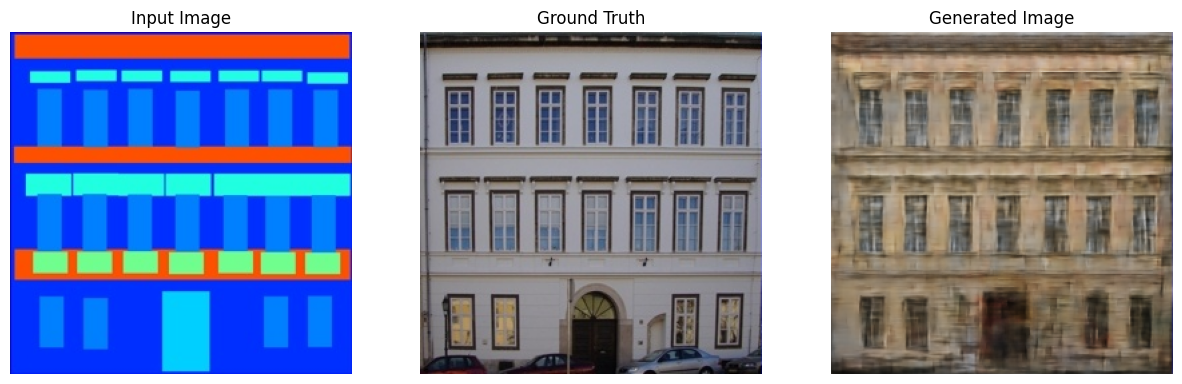

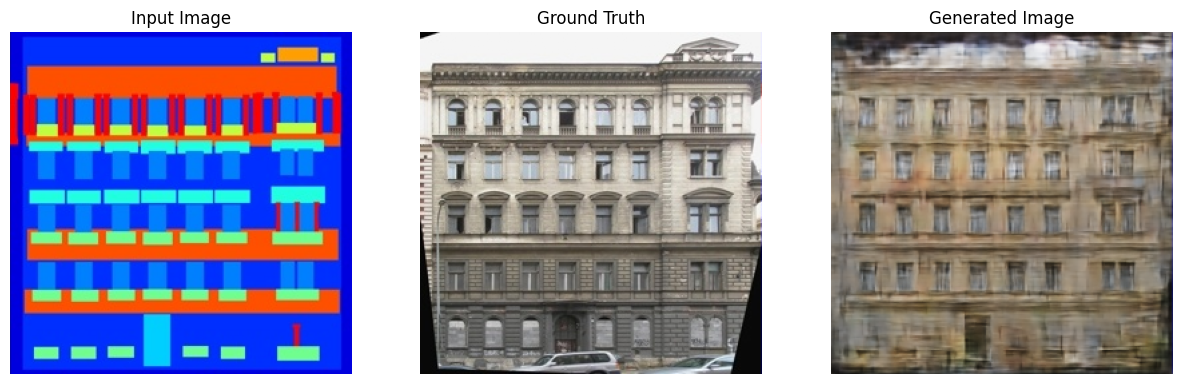

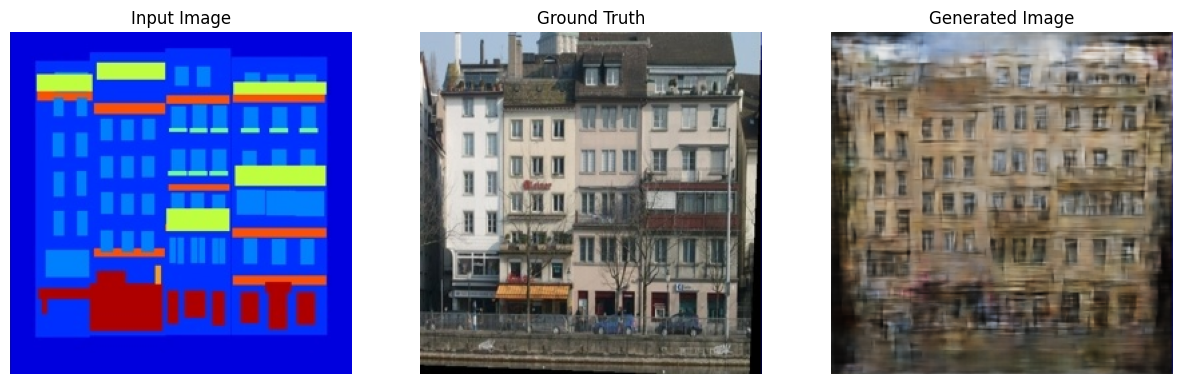

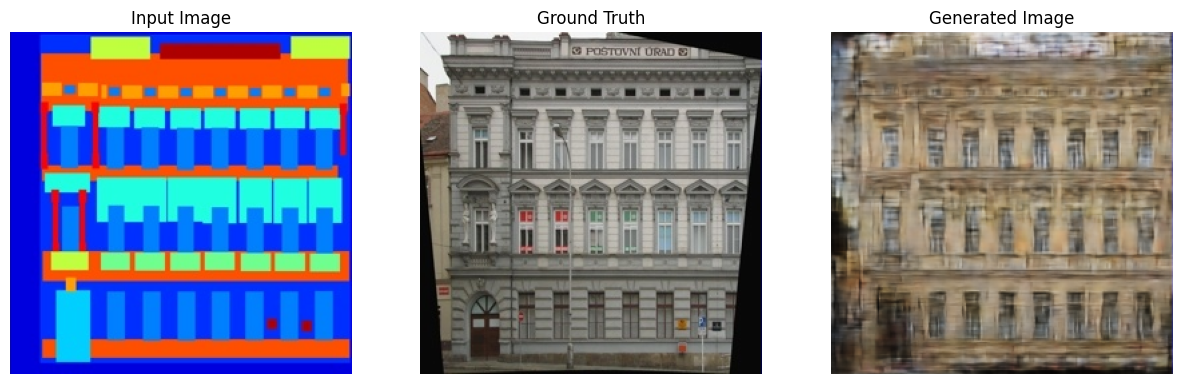

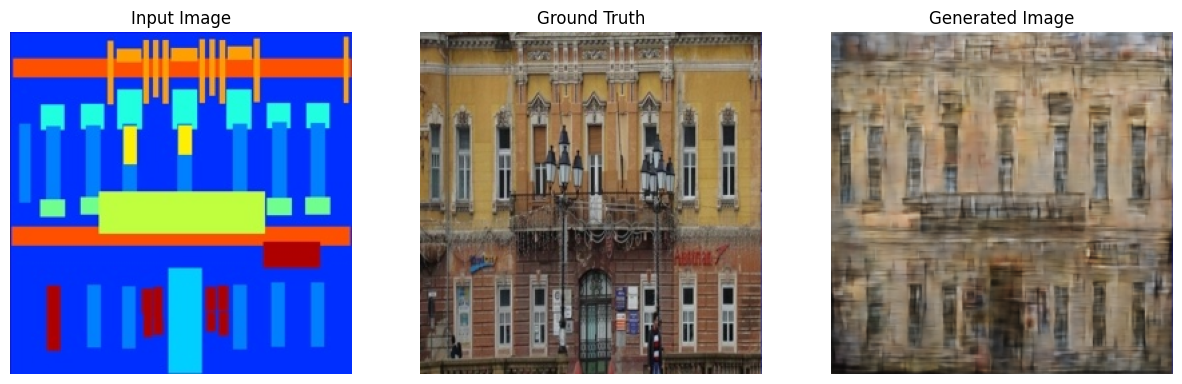

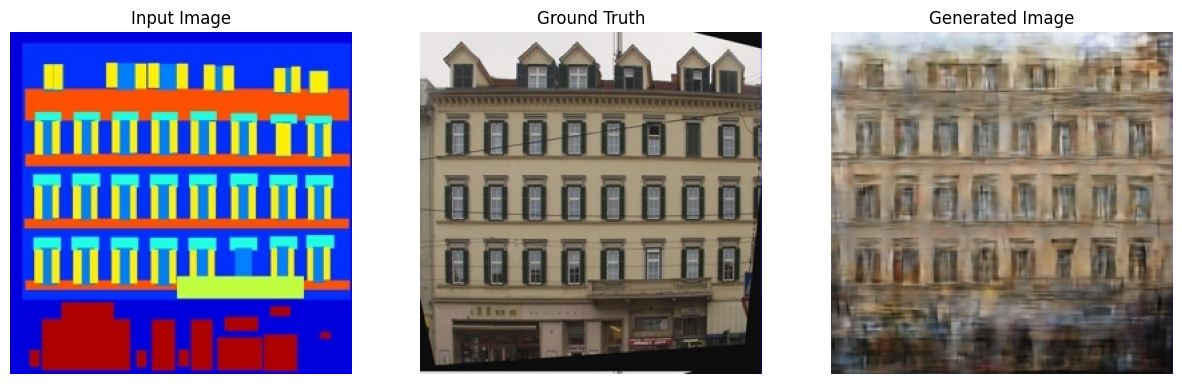

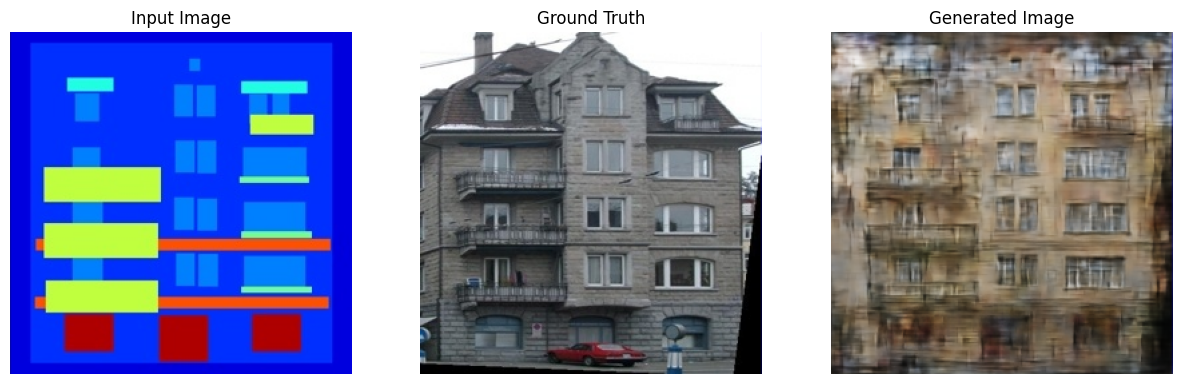

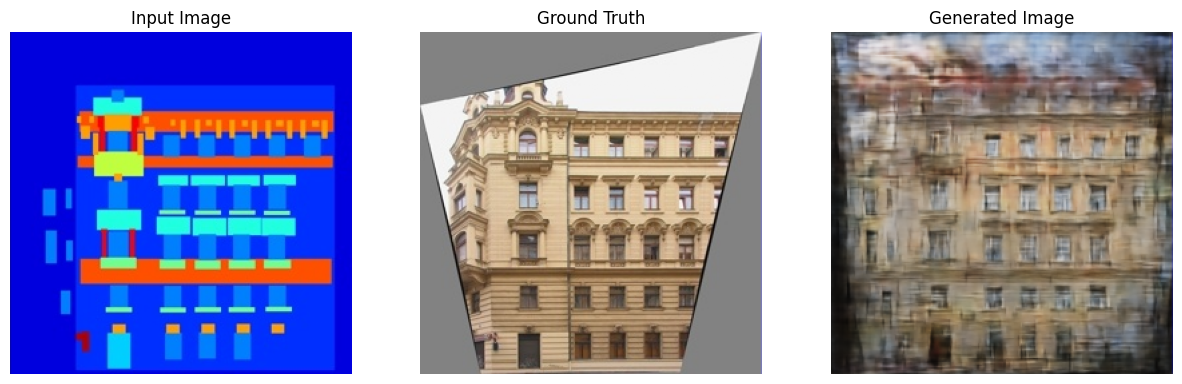

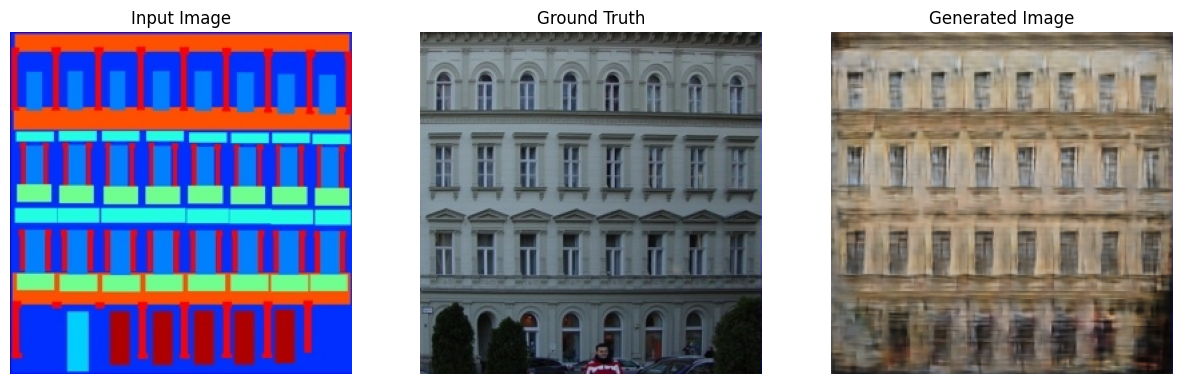

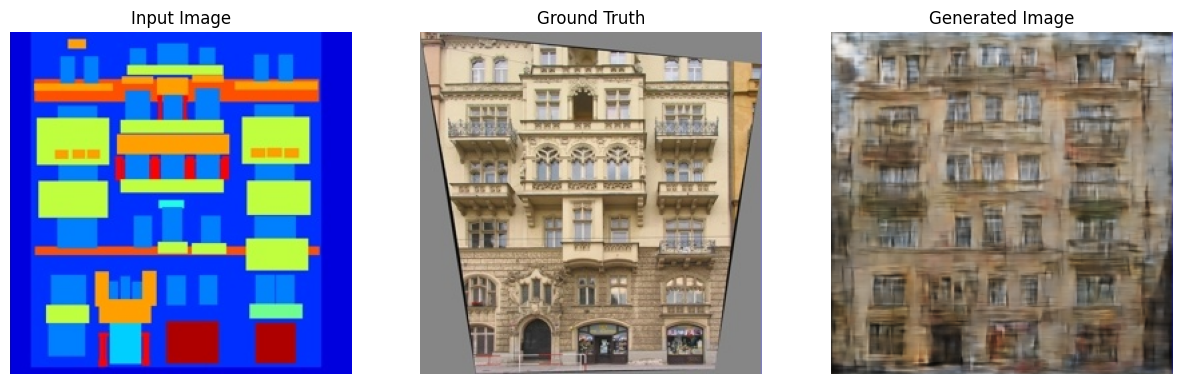


Average SNR: 0.46778401713818313 dB


In [22]:
def calculate_snr(original, generated):
    signal_power = torch.mean(original ** 2)
    noise = original - generated
    noise_power = torch.mean(noise ** 2)
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()


# Set the generator to evaluation mode
generator.eval()

# Initialize lists to store SNR values for each pair
snr_values = []

# Plot and compute SNR for each pair of images
for i, (input_image, target) in enumerate(validation_dataloader):
    if i == 10:
      break

    input_image, target = input_image.to('cuda:0'), target.to('cuda:0')

    # Generate an image using the generator
    generated_image = generator(input_image)

    # Convert the images to numpy arrays
    input_image_np = input_image[0].cpu().numpy().transpose(1, 2, 0)
    target_np = target[0].cpu().numpy().transpose(1, 2, 0)
    generated_image_np = generated_image[0].cpu().detach().numpy().transpose(1, 2, 0)

    # Denormalize the images manually
    input_image_np = (input_image_np * 0.5) + 0.5
    target_np = (target_np * 0.5) + 0.5
    generated_image_np = (generated_image_np * 0.5) + 0.5

    # Compute SNR for the current pair
    snr = calculate_snr(target, generated_image)
    snr_values.append(snr)

    # Plot the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image_np)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(target_np)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(generated_image_np)
    plt.title('Generated Image')
    plt.axis('off')

    plt.show()

# Print average SNR over all pairs
average_snr = sum(snr_values) / len(snr_values)
print(f"\nAverage SNR: {average_snr} dB")